In [2]:
import pandas as pd
import numpy as np
import datetime
import glob
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
import plotly.express as px # express 통해서 그리기
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.rc('font', family='Malgun Gothic')
import networkx as nx
did_info=['현관','복도스팟1','복도스팟2','주방다운','주방','복도스팟3','거실스팟1','거실스팟2','거실1','거실2','거실3','안방','발코니1','방1','방2','욕실1','드레스룸','대피공간','옷장 센서','욕실 다운','욕실2','발코니2','식탁']

In [3]:
#데이터 불러오기
data=pd.read_csv('D:/주거_조명/1210동 1602호/report_data12_0004.csv')
data=data.drop('Unnamed: 0',axis=1)
data['hist_dt']=pd.to_datetime(data['hist_dt'])

#lid 정보 불러오기
lid=pd.read_csv('D:/주거_조명/1210동 1602호/어울림하트 아파트 1210동 1602호.csv ',encoding='cp949')

#lightNo대로 정렬
lid=lid.sort_values(by=['lightNo'])
lid=lid.reset_index(drop=True)
#조명모듈 lid만 가져오기
lid=lid.iloc[0:23]
#x좌표 y좌표 따기
x=lid['x']
y=lid['z']
#did
light_0004_did=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
#did별로 분류
#중복된 시간도 삭제
for i in light_0004_did:
    globals()['data_'+str(i)]=data[data['did']==i]
    #globals()['data_'+str(i)]=globals()['data_'+str(i)].set_index('hist_dt')
    globals()['data_'+str(i)]=globals()['data_'+str(i)].rename(columns={'message':'message_'+str(i)})
    globals()['data_'+str(i)]=globals()['data_'+str(i)][['hist_dt','message_'+str(i)]]
    globals()['data_'+str(i)]=globals()['data_'+str(i)].reset_index(drop=True)
    globals()['data_'+str(i)]=globals()['data_'+str(i)][~globals()['data_'+str(i)].duplicated(subset='hist_dt')]

# P(A)

In [4]:
#각 조명 켜질 확률 구하기
for i in tqdm(light_0004_did):
    globals()['data_'+str(i)+'_on']=(globals()['data_'+str(i)])[(globals()['data_'+str(i)])['message_'+str(i)]=='0 (켜진 상태)']
    globals()['data_'+str(i)+'_on']=globals()['data_'+str(i)+'_on'].reset_index(drop=True)
for i in tqdm(light_0004_did):
    globals()['data'+str(i)+'_on_per']=len(globals()['data_'+str(i)+'_on'])/len(globals()['data_'+str(i)])
a=[]
for i in tqdm(light_0004_did):
    a.append(globals()['data'+str(i)+'_on_per'])
on={'켜질 확률':a}
result_on_per=pd.DataFrame(on,index=light_0004_did)
result_on_per

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


,켜질 확률
1,0.021752
2,0.003403
3,0.003403
4,0.000243
5,0.138899
6,0.003403
7,0.021995
8,0.021995
9,0.096488
10,0.197108


# P(A,B)

In [5]:
#조명 당 같이 켜지는 확률 구하기

#조명끼리 쌍으로 데이터프레임 집합 만들기
#data_1_2->1번 디바이스 데이터프레임과 2번 디바이스 데이터프레임
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['data_'+str(i)+'_'+str(j)]=pd.merge(globals()['data_'+str(i)],globals()['data_'+str(j)])
            
#두 쌍이 동시에 켜진 데이터프레임 만들기
#data_1_2_on
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['data_'+str(i)+'_'+str(j)+'_on']=(globals()['data_'+str(i)+'_'+str(j)])[(globals()['data_'+str(i)+'_'+str(j)]['message_'+str(i)]=='0 (켜진 상태)')&(globals()['data_'+str(i)+'_'+str(j)]['message_'+str(j)]=='0 (켜진 상태)')]
            globals()['data_'+str(i)+'_'+str(j)+'_on']=globals()['data_'+str(i)+'_'+str(j)+'_on'].reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.46it/s]


In [6]:
#교집합확률 구하기
#data_1_2_on_per 1번2번 동시에 켜진 데이터프레임
#result_on_both_per 동시에 켜진 모든결과
b=[]
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['data_'+str(i)+'_'+str(j)+'_on_per']=len(globals()['data_'+str(i)+'_'+str(j)+'_on'])/len(globals()['data_'+str(i)+'_'+str(j)])
            b.append(globals()['data_'+str(i)+'_'+str(j)+'_on_per'])
on_both={'동시에 켜질 확률':b}
device_both=[]
for i in light_0004_did:
    for j in light_0004_did:
        if(i!=j):
            device_both.append((i,j))
result_on_both_per=pd.DataFrame(on_both,index=device_both)

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 11499.46it/s]


In [7]:
#신뢰도
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if i!=j:
            if globals()['data'+str(i)+'_on_per']==0:
                globals()['confidence_'+str(i)+'_'+str(j)]=0
            else:
                globals()['confidence_'+str(i)+'_'+str(j)]=globals()['data_'+str(i)+'_'+str(j)+'_on_per']/globals()['data'+str(i)+'_on_per']
                
#소수점 셋째자리까지
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if i!=j:
            globals()['confidence_'+str(i)+'_'+str(j)]=round(globals()['confidence_'+str(i)+'_'+str(j)],3)

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 22957.88it/s]


In [8]:
df=data.groupby(['did','message']).count()
df
df1=df[['gid']]
df1=df1.rename(columns={'gid':'time'})
df1

time
did message             
1   0 (켜진 상태)        179
    1 (리모컨으로 끈 상태)  8056
    3 (통신장애 상태)        3
2   0 (켜진 상태)         28
    2 (스위치로 끈 상태)   8210
3   0 (켜진 상태)         28
    2 (스위치로 끈 상태)   8210
4   0 (켜진 상태)          2
    2 (스위치로 끈 상태)   8236
5   0 (켜진 상태)       1152
    1 (리모컨으로 끈 상태)   298
    2 (스위치로 끈 상태)   6788
6   0 (켜진 상태)         28
    2 (스위치로 끈 상태)   8210
7   0 (켜진 상태)        181
    2 (스위치로 끈 상태)   8057
8   0 (켜진 상태)        181
    2 (스위치로 끈 상태)   8057
9   0 (켜진 상태)        803
    1 (리모컨으로 끈 상태)    26
    2 (스위치로 끈 상태)   7409
10  0 (켜진 상태)       1622
    1 (리모컨으로 끈 상태)   126
    2 (스위치로 끈 상태)   6490
11  0 (켜진 상태)       1586
    1 (리모컨으로 끈 상태)    26
    2 (스위치로 끈 상태)   6626
12  0 (켜진 상태)        619
    1 (리모컨으로 끈 상태)  3074
    2 (스위치로 끈 상태)   4545
13  0 (켜진 상태)          1
    1 (리모컨으로 끈 상태)     7
    2 (스위치로 끈 상태)   8230
14  0 (켜진 상태)       1196
    1 (리모컨으로 끈 상태)  2616
    2 (스위치로 끈 상태)   4426
15  0 (켜진 상태)        260
    1 (리모컨으로 끈 상태)   534
    2 (스위치로 끈 상태)   7444
16  0 (켜진 상태)        491
    2 (스위치로 끈 상태)   7747
17  0 (켜진 상태)        155
    2 (스위치로 끈 상태)   8083
18  3 (통신장애 상태)     8238
19  0 (켜진 상태)        283
    1 (리모컨으로 끈 상태)  7436
    3 (통신장애 상태)      519
20  0 (켜진 상태)        110
    2 (스위치로 끈 상태)   8128
21  0 (켜진 상태)        223
    1 (리모컨으로 끈 상태)   109
    2 (스위치로 끈 상태)   7906
22  0 (켜진 상태)         53
    1 (리모컨으로 끈 상태)   102
    2 (스위치로 끈 상태)   8083
23  0 (켜진 상태)         24
    2 (스위치로 끈 상태)   8214

In [9]:
#사이즈 조절할때 필요한 켜진 조명시간 데이터프레임 만들기
df=data.groupby(['did','message']).count()
df
df1=df[['gid']]
df1=df1.rename(columns={'gid':'time'})
rs=[]
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23]:
    rs.append(df1['time'].loc[i,'0 (켜진 상태)'])
rs.sort()
rs

[1,
 2,
 24,
 28,
 28,
 28,
 53,
 110,
 155,
 179,
 181,
 181,
 223,
 260,
 283,
 491,
 619,
 803,
 1152,
 1196,
 1586,
 1622]

In [10]:
#edge에 담을 list 만들기
#pattern_1_2
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['pattern_'+str(i)+'_'+str(j)]=[]
#패턴에 담기
#(2번디바이스,3번디바이스,가중치)
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['pattern_'+str(i)+'_'+str(j)].append((did_info[i-1],did_info[j-1],{'confidence':globals()['confidence_'+str(i)+'_'+str(j)]}))

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23029.12it/s]


In [11]:
#신뢰도가 50프로 이상인것만 만들기
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.5:
                globals()['confidence_50over_'+str(i)+'_'+str(j)]=globals()['confidence_'+str(i)+'_'+str(j)]

#edge에 담을 list 만들기
#pattern_1_2
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.5:
                globals()['pattern50_'+str(i)+'_'+str(j)]=[]
#패턴에 담기
#(2번디바이스,3번디바이스,가중치)
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.5:
                globals()['pattern50_'+str(i)+'_'+str(j)].append((did_info[i-1],did_info[j-1],{'confidence':globals()['confidence_50over_'+str(i)+'_'+str(j)]}))                
    

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23029.12it/s]


In [12]:
#신뢰도 70프로 이상인것들만 출력
#(1->2) 1번이 켜졌을때 2번이 켜질 확률이 70프로 이상
#끝에 숫자는 다른 조명들과 연관성이 가장 높음
per_70_device=[]
per_70=[]
number_end=[]
number_start=[]
per=[]
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.7:
                per_70_device.append((did_info[i-1],did_info[j-1]))
                per_70.append(globals()['confidence_'+str(i)+'_'+str(j)])
                number_end.append(did_info[j-1])
                number_start.append(did_info[i-1])
                per.append(globals()['confidence_'+str(i)+'_'+str(j)])
                

per_70_df=pd.DataFrame(per_70,index=per_70_device,columns=['70%이상 켜질확률'])
per_70_df



100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


,70%이상 켜질확률
"(복도스팟1, 복도스팟2)",1.000
"(복도스팟1, 주방)",0.714
"(복도스팟1, 복도스팟3)",1.000
"(복도스팟1, 거실3)",0.750
"(복도스팟2, 복도스팟1)",1.000
"(복도스팟2, 주방)",0.714
"(복도스팟2, 복도스팟3)",1.000
"(복도스팟2, 거실3)",0.750
"(복도스팟3, 복도스팟1)",1.000
"(복도스팟3, 복도스팟2)",1.000


In [13]:
#결과값 데이터프레임
index=pd.MultiIndex.from_tuples(per_70_device)
result1=pd.DataFrame(per,index=index,columns=['A가 켜졌을때 B가 켜질 확률'])
result1.index.names=["A","B"]
result1

A가 켜졌을때 B가 켜질 확률
A     B                      
복도스팟1 복도스팟2             1.000
      주방                0.714
      복도스팟3             1.000
      거실3               0.750
복도스팟2 복도스팟1             1.000
      주방                0.714
      복도스팟3             1.000
      거실3               0.750
복도스팟3 복도스팟1             1.000
      복도스팟2             1.000
      주방                0.714
      거실3               0.750
거실스팟1 거실스팟2             1.000
거실스팟2 거실스팟1             1.000
거실1   거실3               0.996
발코니1  거실2               1.000
      안방                1.000
      방1                1.000
욕실 다운 거실2               0.718
      거실3               0.727
식탁    주방                1.000

In [14]:
did_info=['현관','복도스팟1','복도스팟2','주방다운','주방','복도스팟3','거실스팟1','거실스팟2','거실1','거실2','거실3','안방','발코니1','방1','방2','욕실1','드레스룸','대피공간','옷장 센서','욕실 다운','욕실2','발코니2','식탁']

# 향상도 

In [15]:

for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['data'+str(i)+'_on_per']==0:
                globals()['lift_'+str(i)+'_'+str(j)]=0
            elif globals()['data'+str(j)+'_on_per']==0:
                globals()['lift_'+str(i)+'_'+str(j)]=0
            else:
                globals()['lift_'+str(i)+'_'+str(j)]=globals()['data_'+str(i)+'_'+str(j)+'_on_per']/(globals()['data'+str(i)+'_on_per']* globals()['data'+str(j)+'_on_per'])

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 23029.12it/s]


In [16]:
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            globals()['lift_'+str(i)+'_'+str(j)]=round(globals()['lift_'+str(i)+'_'+str(j)],3)

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 22968.81it/s]


In [17]:
#80프로 이상인 것중에 향상도가 1이상인것만 뽑기
per_more1_device=[]
per_more1=[]
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['lift_'+str(i)+'_'+str(j)]>1:
                per_more1_device.append((did_info[i-1]+'->'+did_info[j-1]))
                per_more1.append(globals()['lift_'+str(i)+'_'+str(j)])
#데이터프레임 만들기
per_more1_df=pd.DataFrame(per_more1,index=per_more1_device,columns=['향상도 1이상 값'])
per_more1_df

100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 22990.70it/s]


,향상도 1이상 값
현관->복도스팟1,3.284
현관->복도스팟2,3.284
현관->주방,3.057
현관->복도스팟3,3.284
현관->거실1,2.142
...,...
식탁->거실3,2.609
식탁->방1,2.587
식탁->방2,2.638
식탁->욕실2,1.538


In [18]:
#켜질확률이 70프로 이고 향상도가 1이상값
result2=pd.merge(per_70_df,per_more1_df,left_index=True, right_index=True)
result2

,70%이상 켜질확률,향상도 1이상 값


In [19]:
'''
#향상도 신뢰도 다 고려한것
result3_device=[]
result3_per=[]
lift_per=[]
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if (i!=j):
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.7:
                if globals()['lift_'+str(i)+'_'+str(j)]>1:
                    result3_device.append((did_info[i-1],did_info[j-1]))
                    result3_per.append(globals()['confidence_'+str(i)+'_'+str(j)])
                    lift_per.append(globals()['lift_'+str(i)+'_'+str(j)])
                
test2134=['일치','일치','불일치','일치','일치','불일치','일치','일치','불일치','불일치','불일치',
        '일치','불일치','일치','일치','불일치','일치' ]
#결과값 데이터프레임
index=pd.MultiIndex.from_tuples(result3_device)
result3=pd.DataFrame({'A가 켜졌을때 B가 켜질 확률(신뢰도)':result3_per,'향상도':lift_per,'검정':test2134},index=index)
result3.index.names=["A","B"]
result3
'''

'\n#향상도 신뢰도 다 고려한것\nresult3_device=[]\nresult3_per=[]\nlift_per=[]\nfor i in tqdm(light_0004_did):\n    for j in light_0004_did:\n        if (i!=j):\n            if globals()[\'confidence_\'+str(i)+\'_\'+str(j)]>0.7:\n                if globals()[\'lift_\'+str(i)+\'_\'+str(j)]>1:\n                    result3_device.append((did_info[i-1],did_info[j-1]))\n                    result3_per.append(globals()[\'confidence_\'+str(i)+\'_\'+str(j)])\n                    lift_per.append(globals()[\'lift_\'+str(i)+\'_\'+str(j)])\n                \ntest2134=[\'일치\',\'일치\',\'불일치\',\'일치\',\'일치\',\'불일치\',\'일치\',\'일치\',\'불일치\',\'불일치\',\'불일치\',\n        \'일치\',\'불일치\',\'일치\',\'일치\',\'불일치\',\'일치\' ]\n#결과값 데이터프레임\nindex=pd.MultiIndex.from_tuples(result3_device)\nresult3=pd.DataFrame({\'A가 켜졌을때 B가 켜질 확률(신뢰도)\':result3_per,\'향상도\':lift_per,\'검정\':test2134},index=index)\nresult3.index.names=["A","B"]\nresult3\n'

100%|██████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<?, ?it/s]


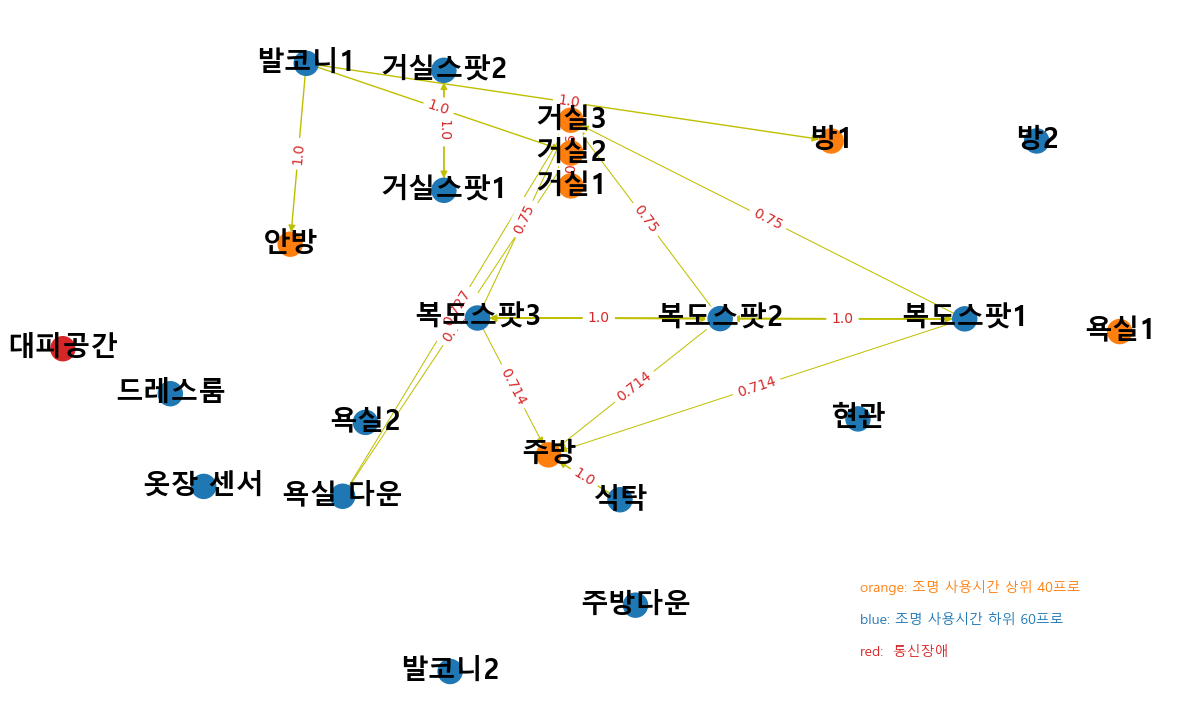

In [20]:
#G 그래프
G = nx.DiGraph()
#did로 노드 추가
G.add_nodes_from(did_info)
#노드속성 켜진 시간으로 
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23]:
    G.nodes[did_info[i-1]]['on_time']=df1['time'].loc[i,'0 (켜진 상태)']
    G.nodes[did_info[i-1]]['on']=0
G.nodes[did_info[18-1]]['on_time']=0
G.nodes[did_info[18-1]]['on']=1
#node 속성에 따라 크기 설정하기 위해 node 속성만 가져옴
size_node=nx.get_node_attributes(G,'on_time')
size_device=[size_node.get(node) for node in G.nodes()]
#노드 위치 추가
#노두 위치 추가
test_lid={}
for i in range(23):
    test_lid[did_info[i]]=[x[i],y[i]]
test_lid
#색상 변경

color_map=nx.get_node_attributes(G,'on_time')
for key in color_map:
    if color_map[key]==0:
        color_map[key]="tab:red"
    elif color_map[key]>=284:
        color_map[key]='tab:orange'
    else:
        color_map[key]='tab:blue'
color_device=[color_map.get(node) for node in G.nodes()]
#엣지추가
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if i!=j:
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.7:
                if globals()['lift_'+str(i)+'_'+str(j)]>1:
                    G.add_edges_from(globals()['pattern_'+str(i)+'_'+str(j)])
#엣지 색깔
edge_color_map=nx.get_edge_attributes(G,'confidence')
for key in edge_color_map:
    if edge_color_map[key]>0.7:
        edge_color_map[key]='y'
    else:
         edge_color_map[key]='black'
edge_colors=[edge_color_map.get(edge) for edge in G.edges()]            

#엣지 정보
edge_labels = dict([((n1, n2), d['confidence'])
                    for n1, n2, d in G.edges(data=True)])
#엣지 넓이
edges = G.edges()
test=[G[u][v]['confidence'] for u,v in edges]

#마무리
plt.figure(figsize=(15,9))
#plt.title('1210동 1602호 조명 패턴',fontsize=20)
#plt.text(60,-10,'신뢰도가 70프로 이상 그리고 향상도 값 1 이상 ',fontsize=14)
plt.text(130,-100,'orange: 조명 사용시간 상위 40프로',fontsize=10,color='tab:orange')
plt.text(130,-105,'blue: 조명 사용시간 하위 60프로',fontsize=10,color='tab:blue')
plt.text(130,-110,'red:  통신장애 ',fontsize=10,color='tab:red')
#plt.text(130,-115,'초록색선은 신뢰도가 70프로 이상',fontsize=10)
plt.rc('font', family='Malgun Gothic')

nx.draw(G,test_lid, with_labels=True,node_color=color_device,font_size=20,font_color="black",font_family='Malgun Gothic',font_weight='heavy',width=test,edge_color=edge_colors)

nx.draw_networkx_edge_labels(G, test_lid, edge_labels=edge_labels, label_pos=0.5,
                             font_color='tab:red', font_size=10)

plt.savefig('D:/주거_조명/1210동 1602호/1210동_1602호_조명패턴1(신뢰도 50프로이상,향상도).png')
plt.show()

In [21]:
shape_device=['*',
 '*',
 '*',
 '*',
 'o',
 '*',
 '*',
 '*',
 'o',
 'o',
 'o',
 'o',
 '*',
 'o',
 '*',
 'o',
 '*',
 '^',
 '*',
 '*',
 '*',
 '*',
 '*']
node_styles={}
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23]:
    node_styles[did_info[i-1]]={"node_shape":shape_device[i-1],"node_color":color_device[i-1]}
node_styles

{'현관': {'node_shape': '*', 'node_color': 'tab:blue'},
 '복도스팟1': {'node_shape': '*', 'node_color': 'tab:blue'},
 '복도스팟2': {'node_shape': '*', 'node_color': 'tab:blue'},
 '주방다운': {'node_shape': '*', 'node_color': 'tab:blue'},
 '주방': {'node_shape': 'o', 'node_color': 'tab:orange'},
 '복도스팟3': {'node_shape': '*', 'node_color': 'tab:blue'},
 '거실스팟1': {'node_shape': '*', 'node_color': 'tab:blue'},
 '거실스팟2': {'node_shape': '*', 'node_color': 'tab:blue'},
 '거실1': {'node_shape': 'o', 'node_color': 'tab:orange'},
 '거실2': {'node_shape': 'o', 'node_color': 'tab:orange'},
 '거실3': {'node_shape': 'o', 'node_color': 'tab:orange'},
 '안방': {'node_shape': 'o', 'node_color': 'tab:orange'},
 '발코니1': {'node_shape': '*', 'node_color': 'tab:blue'},
 '방1': {'node_shape': 'o', 'node_color': 'tab:orange'},
 '방2': {'node_shape': '*', 'node_color': 'tab:blue'},
 '욕실1': {'node_shape': 'o', 'node_color': 'tab:orange'},
 '드레스룸': {'node_shape': '*', 'node_color': 'tab:blue'},
 '옷장 센서': {'node_shape': '*', 'node_color':

In [22]:
from PIL import Image
#H 그래프
H = nx.DiGraph()
#did로 노드 추가
H.add_nodes_from(did_info)
#노드속성 켜진 시간으로 
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23]:
    H.nodes[did_info[i-1]]['on_time']=df1['time'].loc[i,'0 (켜진 상태)']
    H.nodes[did_info[i-1]]['on']=0
H.nodes[did_info[18-1]]['on_time']=0
H.nodes[did_info[18-1]]['on']=1
H.nodes

NodeView(('현관', '복도스팟1', '복도스팟2', '주방다운', '주방', '복도스팟3', '거실스팟1', '거실스팟2', '거실1', '거실2', '거실3', '안방', '발코니1', '방1', '방2', '욕실1', '드레스룸', '대피공간', '옷장 센서', '욕실 다운', '욕실2', '발코니2', '식탁'))

In [23]:
from itertools import cycle
#H 그래프
H = nx.DiGraph()
#did로 노드 추가
H.add_nodes_from(did_info)
#노드속성 켜진 시간으로 
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23]:
    H.nodes[did_info[i-1]]['on_time']=df1['time'].loc[i,'0 (켜진 상태)']
    H.nodes[did_info[i-1]]['on']=0
H.nodes[did_info[18-1]]['on_time']=0
H.nodes[did_info[18-1]]['on']=1
#node 속성에 따라 크기 설정하기 위해 node 속성만 가져옴
size_node=nx.get_node_attributes(H,'on_time')
size_device=[size_node.get(node) for node in H.nodes()]
#노드 위치 추가
#노두 위치 추가
test_lid={}
for i in range(23):
    test_lid[did_info[i]]=[x[i],y[i]]
test_lid
#색상 변경
#색상 변경
color_map=nx.get_node_attributes(H,'on_time')
for key in color_map:
    if color_map[key]==0:
        color_map[key]="tab:blue"
    elif color_map[key]>=284:
        color_map[key]='tab:orange'
    else:
        color_map[key]='tab:blue'
color_device=[color_map.get(node) for node in H.nodes()]


#노드 모형
shape_map=nx.get_node_attributes(H,'on_time')
for key in shape_map:
    if shape_map[key]==0:
        shape_map[key]="o"
    elif shape_map[key]>=284:
        shape_map[key]='s'
    else:
        shape_map[key]='^'
shape_device=[shape_map.get(node) for node in H.nodes()]

shape_device_cycle=cycle(shape_device)
for node in H.nodes():
    nx.set_node_attributes(H,{node:{"node_shape": next(shape_device_cycle)}})




#엣지추가
for i in tqdm(light_0004_did):
    for j in light_0004_did:
        if i!=j:
            if globals()['confidence_'+str(i)+'_'+str(j)]>0.5:
                H.add_edges_from(globals()['pattern50_'+str(i)+'_'+str(j)])
#엣지 색깔
edge_color_map=nx.get_edge_attributes(H,'confidence')
for key in edge_color_map:
    if edge_color_map[key]>=0.7:
        edge_color_map[key]='green'
    elif (edge_color_map[key]>=0.5)&(edge_color_map[key]<0.6):
        edge_color_map[key]='black'
    elif (edge_color_map[key]>=0.6)&(edge_color_map[key]<0.7):
        edge_color_map[key]='purple'
edge_colors=[edge_color_map.get(edge) for edge in H.edges()]            

#엣지 정보
edge_labels = dict([((n1, n2), d['confidence'])
                    for n1, n2, d in H.edges(data=True)])
#엣지 넓이
edges = H.edges()
test=[H[u][v]['confidence'] for u,v in edges]

#엣지 스타일
edge_style_map=nx.get_edge_attributes(H,'confidence')
for key in edge_style_map:
    if edge_style_map[key]>=0.7:
        edge_style_map[key]='dashed'
    elif (edge_style_map[key]>=0.5)&(edge_style_map[key]<0.6):
        edge_style_map[key]='solid'
    elif (edge_style_map[key]>=0.6)&(edge_style_map[key]<0.7):
        edge_style_map[key]='dotted'
edge_styles=[edge_style_map.get(edge) for edge in H.edges()]    

#마무리
plt.figure(figsize=(5,5))
#plt.title('1210동 1602호 조명 패턴(아파트 실제 배치도)',fontsize=30,fontweight='heavy')
plt.text(20,-120,'신뢰도 50%~59%: 검은색(실선),   60%~69%: 보라색(점선),   70%~100%: 초록색(파선)',fontsize=20)
plt.text(130,-95,'노드 색깔 구분',fontsize=20)
plt.text(130,-100,'orange: 조명 사용시간 상위 40프로',fontsize=20,color='tab:orange')
plt.text(130,-105,'blue: 조명 사용시간 하위 60프로',fontsize=20,color='tab:blue')
plt.text(130,-110,'red:  설치 취소 ',fontsize=20,color='tab:red')
#plt.text(130,-115,'초록색선은 신뢰도가 70프로 이상',fontsize=10)
plt.rc('font', family='Malgun Gothic')

nx.draw(H,test_lid, with_labels=True,node_color=color_device,node_shape='s','o',font_color="black",font_family='Malgun Gothic',edge_color=edge_colors,font_weight='heavy',width=2.5,style=edge_styles)



nx.draw_networkx_edge_labels(H, test_lid, edge_labels=edge_labels, label_pos=0.5,
                             font_color='tab:red', font_size=12)

plt.savefig('D:/주거_조명/1210동 1602호/1210동_1602호_조명패턴1(논문용).png')
plt.show()

SyntaxError: positional argument follows keyword argument (2642921733.py, line 98)

In [ ]:
node_shapes = ['s'  if i % 2 == 0 else 'o' for i in range(len(G.nodes()))]
for i,node in enumerate(G.nodes()):
    print(node)
    
    G.nodes[node]['shape'] = node_shapes[i]
for shape in set(node_shapes):
    # the nodes with the desired shapes
    node_list = [node for node in G.nodes() if G.nodes[node]['shape'] == shape]
node_list


In [ ]:
G=nx.Graph()

G.add_edges_from([("1", "2" ), ("3", "2"),("4", "2"), ("2", "5"),("5", "6"),("6", "7")])

pos = {"1": [0,1],
       "2": [1,0],
       "3": [0,0],
       "4": [0,-1],
       "5": [2,0],
       "6": [3,0],
       "7": [4,0]
       }
# Add plotting data as node attributes
node_colors= ["#80d189","#de3737","#80d189","#80d189","#ccbfbe","#ccbfbe","#ccbfbe"]
node_sizes = [3000,15000,3000,3000,3000,3000,3000]
# odd nodes as squares even as circles
node_shapes = ['s'  if i % 2 == 0 else 'o' for i in range(len(G.nodes()))]
for i,node in enumerate(G.nodes()):
    G.nodes[node]['color'] = node_colors[i]
    G.nodes[node]['size'] = node_sizes[i]
    G.nodes[node]['shape'] = node_shapes[i]

#%% Draw Graph
nx.draw_networkx_edges(G,pos) # draw edges
nx.draw_networkx_labels(G,pos) # draw node labels

# Draw the nodes for each shape with the shape specified
for shape in set(node_shapes):
    # the nodes with the desired shapes
    node_list = [node for node in G.nodes() if G.nodes[node]['shape'] == shape]
    nx.draw_networkx_nodes(G,pos,
                           nodelist = node_list,
                           node_size = [G.nodes[node]['size'] for node in node_list],
                           node_color= [G.nodes[node]['color'] for node in node_list],
                           node_shape = shape)

In [ ]:
shape_device_cycle=cycle(shape_device)
for node in H.nodes():
    nx.set_node_attributes(H,{node:{"node_shape": next(node_device_cycle)}})

In [ ]:
H.nodes['현관']

In [ ]:
#H 그래프
H = nx.DiGraph()
#did로 노드 추가
H.add_nodes_from(did_info)
#노드속성 켜진 시간으로 
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23]:
    H.nodes[did_info[i-1]]['on_time']=df1['time'].loc[i,'0 (켜진 상태)']
    H.nodes[did_info[i-1]]['on']=0
H.nodes[did_info[18-1]]['on_time']=0
H.nodes[did_info[18-1]]['on']=1
#node 속성에 따라 크기 설정하기 위해 node 속성만 가져옴
size_node=nx.get_node_attributes(H,'on_time')
size_device=[size_node.get(node) for node in H.nodes()]
#노드 위치 추가
#노두 위치 추가
test_lid={}
for i in range(23):
    test_lid[did_info[i]]=[x[i],y[i]]
test_lid
#색상 변경
#색상 변경
color_map=nx.get_node_attributes(H,'on_time')
for key in color_map:
    if color_map[key]==0:
        color_map[key]="tab:red"
    elif color_map[key]>=284:
        color_map[key]='tab:orange'
    else:
        color_map[key]='tab:blue'
color_device=[color_map.get(node) for node in H.nodes()]


#마무리
plt.figure(figsize=(15,9))
#plt.title('1210동 1602호 조명 노드',fontsize=20)

plt.text(130,-100,'orange: 조명 사용시간 상위 40프로',fontsize=10,color='tab:orange')
plt.text(130,-105,'blue: 조명 사용시간 하위 60프로',fontsize=10,color='tab:blue')
plt.text(130,-110,'red:  통신장애 ',fontsize=10,color='tab:red')
#plt.text(130,-115,'초록색선은 신뢰도가 70프로 이상',fontsize=10)
plt.rc('font', family='Malgun Gothic')

nx.draw(H,test_lid, with_labels=True,node_color=color_device,font_size=20,font_color="black",font_family='Malgun Gothic',font_weight='heavy')

#nx.draw_networkx_edge_labels(H, test_lid, edge_labels=edge_labels, label_pos=0.5,
#                             font_color='tab:red', font_size=6)

plt.savefig('D:/주거_조명/1210동 1602호/1210동_1602호_노드(신뢰도 50프로이상).png')
plt.show()

In [ ]:
# 신뢰도 50프로 이상인것만 그리기

# 신뢰도 50프로 이상만 고려

* 신뢰도 50프로 이상인 것만 그리기
* 신뢰도 70프로 이상인것은 초록색
* 신뢰도 70프로 이상인 것에다가 향상도가 1인것은 노란색

In [ ]:
result3_device
test=[('복도스팟1', '복도스팟2'),('복도스팟1', '복도스팟3'),('복도스팟2', '복도스팟1'),
 ('복도스팟2', '복도스팟3'),('복도스팟2', '복도스팟1'),
 ('복도스팟2', '복도스팟3'),('거실1', '거실3'),('발코니1', '안방'),('식탁', '주방')]

index=pd.MultiIndex.from_tuples(result3_device)
result3=pd.DataFrame({'A가 켜졌을때 B가 켜질 확률':result3_per,'향상도':lift_per},index=index)
result3.index.names=["A","B"]
result3